# Prepare Dataset

Download data and model

In [ ]:
!unzip -uq bd.zip -d data
!unzip -uq cl.zip -d data
!wget https://github.com/csaw-hackml/CSAW-HackML-2020/raw/master/lab3/models/bd_net.h5

--2021-12-16 23:04:45--  https://github.com/csaw-hackml/CSAW-HackML-2020/raw/master/lab3/models/bd_net.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/csaw-hackml/CSAW-HackML-2020/master/lab3/models/bd_net.h5 [following]
--2021-12-16 23:04:45--  https://raw.githubusercontent.com/csaw-hackml/CSAW-HackML-2020/master/lab3/models/bd_net.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7275748 (6.9M) [application/octet-stream]
Saving to: ‘bd_net.h5.1’

bd_net.h5.1         100%[===================>]   6.94M  --.-KB/s    in 0.09s   

2021-12-16 23:04:46 (78.2 MB/s) - ‘bd_net.h5.1’ saved [7275748/7

Load data and model

In [2]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
cl_va_data = h5py.File("data/cl/cl/valid.h5", 'r')
bd_va_data = h5py.File("data/bd/bd/bd_valid.h5", 'r')
cl_ts_data = h5py.File("data/cl/cl/test.h5", 'r')
bd_ts_data = h5py.File("data/bd/bd/bd_test.h5", 'r')

cl_va_x = np.array(cl_va_data['data']).transpose((0,2,3,1))
cl_va_y = np.array(cl_va_data['label'])
bd_va_x = np.array(bd_va_data['data']).transpose((0,2,3,1))
bd_va_y = np.array(bd_va_data['label'])
cl_ts_x = np.array(cl_ts_data['data']).transpose((0,2,3,1))
cl_ts_y = np.array(cl_ts_data['label'])
bd_ts_x = np.array(bd_ts_data['data']).transpose((0,2,3,1))
bd_ts_y = np.array(bd_ts_data['label'])

print(cl_va_x.shape)
print(cl_va_y.shape)
print(bd_va_x.shape)
print(bd_va_y.shape)
print(cl_ts_x.shape)
print(cl_ts_y.shape)
print(bd_ts_x.shape)
print(bd_ts_y.shape)

(11547, 55, 47, 3)
(11547,)
(11547, 55, 47, 3)
(11547,)
(12830, 55, 47, 3)
(12830,)
(12830, 55, 47, 3)
(12830,)


In [4]:
BadNet = keras.models.load_model("bd_net.h5")

In [5]:
# test on original model
cl_pred = np.argmax(BadNet.predict(cl_va_x), axis=1)
cl_acc = np.mean(np.equal(cl_pred, cl_va_y))
bd_pred = np.argmax(BadNet.predict(bd_va_x), axis=1)
bd_acc = np.mean(np.equal(bd_pred, bd_va_y))

print("Accuracy on the clean dataset", cl_acc)
print('Success rate of attact backdoored dataset:', bd_acc)

Accuracy on the clean dataset 0.9864899974019226
Success rate of attact backdoored dataset: 1.0


# Pruning Defense

Print the backdoored model information to find the last pooling layer and the number of total classes

In [6]:
BadNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Get the activation list with increading order

In [7]:
# split the whole BadNet into 2 subNet by the last pooling layer 
subNet1 = keras.Model(inputs = BadNet.input, outputs = BadNet.layers[6].output)
subNet2 = keras.Model(inputs = BadNet.layers[7].input, outputs = BadNet.output)
# get the output value after the last pooling layer 
activations = subNet1.predict(cl_va_x)
print(activations.shape)
# calculate the average values
avg_activations = np.mean(activations, axis=0)
# the indexes in increasing order
ordered_indexes = np.unravel_index(np.argsort(avg_activations, axis=None), avg_activations.shape)
print(len(ordered_indexes))

(11547, 5, 4, 60)
3


Repair the bad net by pruning neurals

In [8]:
# subNet1 --RepairedSubNet--> subNet2 
def RepairedSubNet(custom_mask):
  mask = tf.Variable(custom_mask, trainable=False, dtype=tf.float32)
  masked = keras.layers.Lambda(lambda x: x * mask)(subNet1.output)
  return keras.Model(inputs=subNet1.output, outputs=subNet2(masked))

# prune the neural or not with the value of 0 or 1 
def PruningDefense(drop_rate):
  prune_mask = np.ones(activations[0].shape)
  num_neurals = activations[0].shape[0] * activations[0].shape[1] * activations[0].shape[2]
  for i in range(num_neurals):
    # prune one neural, by setting the mask to be 0
    prune_mask[ordered_indexes[0][i], ordered_indexes[1][i], ordered_indexes[2][i]] = 0
    if i <= 900:
      continue # to save time
    repairedSubNet = RepairedSubNet(prune_mask)
    pruned_pred = np.argmax(repairedSubNet.predict(activations), axis=1)
    repaired_acc = np.mean(np.equal(pruned_pred, cl_va_y))
    # stop once acheiving the drop rate
    if repaired_acc <= cl_acc - drop_rate:
      print("i:", i, " repaired_acc:", repaired_acc, " drop:", cl_acc - repaired_acc)
      break
  return repairedSubNet, prune_mask

In [9]:
# record each mask
path = "models/repairedNet"
drop_rate = [0.02, 0.04, 0.1] # [0.02, 0.04, 0.1]
repairedSubNets = []
repairedSubNet = []
masks = []
mask = []
for rate in drop_rate:
  print(rate)
  repairedSubNet, mask = PruningDefense(rate)
  #repairedSubNet.save(path + str(rate * 100) + ".h5")
  repairedSubNets.append(repairedSubNet)
  masks.append(mask)

0.02
i: 928  repaired_acc: 0.9660517883432926  drop: 0.02043820905862992
0.04
i: 964  repaired_acc: 0.946306399930718  drop: 0.04018359747120459
0.1
i: 1023  repaired_acc: 0.8852515804970988  drop: 0.10123841690482371


Test on test_dataset

In [10]:
def Predict(repairedNet, ts_x, ts_y):
  original_pred = np.argmax(BadNet.predict(ts_x), axis=1)
  pooling_activation = subNet1.predict(ts_x)
  repaired_pred = np.argmax(repairedNet.predict(pooling_activation), axis=1)
  ts_pred = []
  for o_pred, r_pred in zip(original_pred, repaired_pred):
    if o_pred == r_pred:
      ts_pred.append(o_pred) # correct class
    else:
      ts_pred.append(1283) # class N+1
  return ts_pred

In [11]:
cl_accuracy = []
defense_acc = []
for RepairedNet in repairedSubNets:
  # test on clean test dataset
  cl_ts_pred = Predict(RepairedNet, cl_ts_x, cl_ts_y)
  acc = np.mean(np.equal(cl_ts_pred, cl_ts_y))
  cl_accuracy.append(acc)
  print("cl:", acc)

  # test on doorback test dataset
  bd_ts_pred = Predict(RepairedNet, bd_ts_x, bd_ts_y)
  acc = np.mean(np.equal(bd_ts_pred, bd_ts_y))
  defense_acc.append(acc)
  print("bd:", acc)

cl: 0.9658612626656274
bd: 0.9999220576773188
cl: 0.9477786438035853
bd: 0.9846453624318005
cl: 0.8809041309431022
bd: 0.6316445830085736


# Plot Accuracy and Attack Success Rate

In [12]:
acc = []
asr = []
per = []

prune_mask = np.ones(activations[0].shape)
num_neurals = activations[0].shape[0] * activations[0].shape[1] * activations[0].shape[2]
for i in range(num_neurals):
  prune_mask[ordered_indexes[0][i], ordered_indexes[1][i], ordered_indexes[2][i]] = 0
  if i % 50 == 0:
    per.append((i + 1) / num_neurals)
    repairedSubNet = RepairedSubNet(prune_mask)
    # the accuracy on clean test data
    original_pred = np.argmax(BadNet.predict(cl_ts_x), axis=1)
    pruned_pred = np.argmax(repairedSubNet.predict(subNet1.predict(cl_ts_x)), axis=1)
    pruned_pred = np.where(original_pred == pruned_pred, original_pred, 1283)
    repaired_acc = np.mean(np.equal(pruned_pred, original_pred))
    acc.append(repaired_acc)
    # the attack success rate on backdoored test data
    original_pred = np.argmax(BadNet.predict(bd_ts_x), axis=1)
    bd_pred = np.argmax(repairedSubNet.predict(subNet1.predict(bd_ts_x)), axis=1)
    bd_pred = np.where(original_pred == bd_pred, original_pred, 1283)
    att_suc_rate = np.mean(np.equal(bd_pred, original_pred))
    asr.append(att_suc_rate)

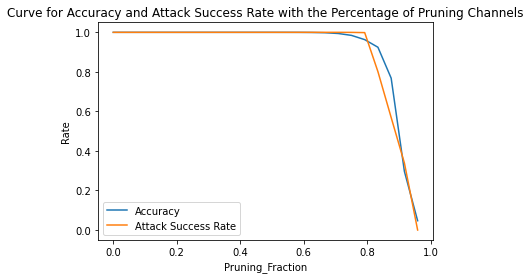

In [13]:
plt.figure()
plt.plot(per, acc, label="Accuracy")
plt.plot(per, asr, label="Attack Success Rate")
plt.xlabel("Pruning_Fraction")
plt.ylabel("Rate")
plt.title('Curve for Accuracy and Attack Success Rate with the Percentage of Pruning Channels')
plt.legend()
plt.savefig("plot.png")
plt.show()

As shown in the plot, the accuracy on the clean test data and the attack succuss rate is very high and stable until the percentage comes to a high value around 0.8. After that, bothe the accuracy and the attack success rate drop quickly, and the accuracy even drops before the attack success rate, which means the pruning defense doesn't work well in this case.  